In [59]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [60]:
import numpy as np
import pandas as pd

In [61]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [62]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [63]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [64]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [65]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [66]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station



In [67]:
# Create our session (link) from Python to the DB

session = Session(engine)



# Exploratory Climate Analysis

In [68]:
first_row = session.query(Measurement).first()
first_row.__dict__




{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x114009e10>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [69]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x114fc1250>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'latitude': 21.2716,
 'id': 1,
 'station': 'USC00519397',
 'elevation': 3.0}

In [70]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

session.query(Measurement.date).order_by(Measurement.date.desc()).all()


# Calculate the date 1 year ago from the last data point in the database
date_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

precipitation_scores = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > date_year_ago).\
    order_by(Measurement.date).all()

# precipitation_scores

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_scores_df = pd.DataFrame(precipitation_scores,columns=['date','prcp'])

precipitation_scores_df.set_index('date',inplace=True)

# Sort the dataframe by date

sorted_df=precipitation_scores_df.sort_values(by='date')

sorted_df


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


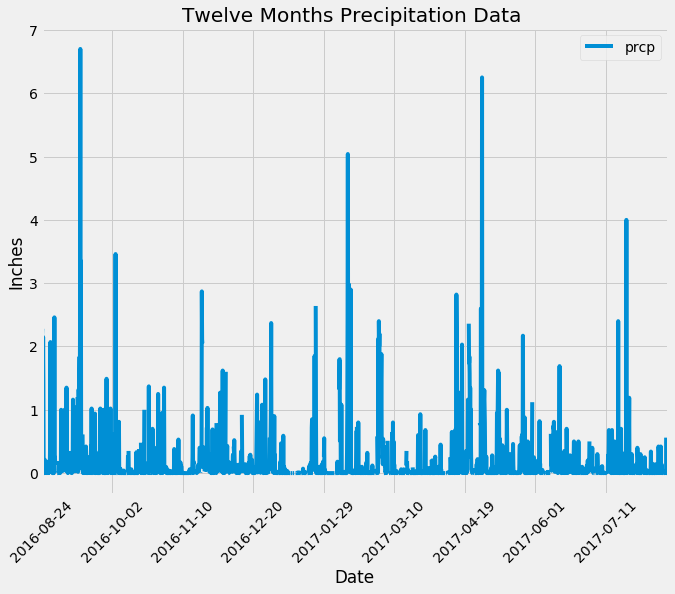

In [72]:

# Use Pandas Plotting with Matplotlib to plot the data

sorted_df.plot(x_compat=True , figsize=(10,8))

plt.title('Twelve Months Precipitation Data ')
plt.ylabel('Inches')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation='45')
plt.savefig('Precipitation.png')

In [73]:
# Use Pandas to calcualte the summary statistics for the precipitation data

sorted_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [74]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Measurement).group_by(Measurement.station).count()

print(f"There are {total_stations} stations ")

There are 9 stations 


In [75]:
# What are the most active stations? (i.e. what stations have the most rows)?

active_stations = session.query(Measurement.station,func.count(Measurement.station))\
               .group_by(Measurement.station).all()

# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station,func.count(Measurement.station))\
               .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [76]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

   #finding the most active station 

most_active = active_stations[0][0]


temperatures = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                            filter(Measurement.station == most_active).all()
                       
temperatures

[(54.0, 85.0, 71.66378066378067)]

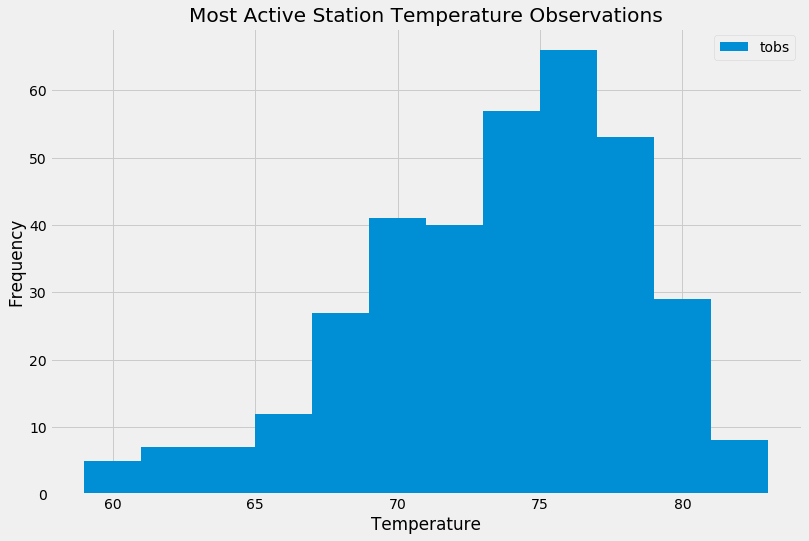

<Figure size 432x288 with 0 Axes>

In [77]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

Highest_tempobs = session.query(Measurement.station,Measurement.tobs).filter(Measurement.station == most_active).\
                                filter(Measurement.date >=date_year_ago). all()

Highest_tempobs_df = pd.DataFrame(Highest_tempobs)


Highest_tempobs_df


#plotting the histogram

Highest_tempobs_df.plot.hist(bins = 12, figsize=(12,8))
plt.title ('Most Active Station Temperature Observations')
plt.xlabel ('Temperature')
plt.ylabel ('Frequency')

plt.show()

plt.savefig("station-histogram.png")

## Bonus Challenge Assignment

In [168]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example

print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [172]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temp_records = calc_temps('2012-01-15', '2012-01-30')
temp_records



[(58.0, 70.86046511627907, 78.0)]

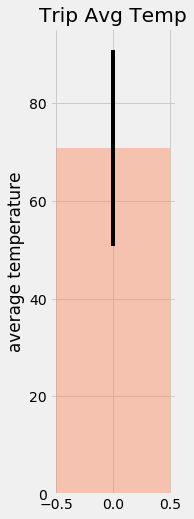

In [202]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin = temp_records[0][0]
tavg = temp_records[0][1]
tmax = temp_records[0][2]
y_err = tmax-tmin
plt.figure(figsize=(2,8))
plt.bar(0,tavg,yerr=y_err,color="coral",alpha=0.4,width=1)
plt.ylabel("average temperature")
plt.title("Trip Avg Temp")
plt.savefig("temperature.png")


In [82]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [83]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [84]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [85]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [86]:
# Plot the daily normals as an area plot with `stacked=False`
